In [ ]:
! pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# from xgboost.sklearn import XGBClassifier
# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# subsample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
# clustering
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('train.csv')
train_ft = pd.read_csv('train_ft.csv')

In [ ]:
col_to_use = train_ft.columns.difference(train.columns)
col_to_use = col_to_use.tolist()
col_to_use.append('SK_ID_CURR')
train = train.merge(train_ft[col_to_use], on='SK_ID_CURR', how='right')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,SUM(prev.SKEW(pc.CNT_INSTALMENT)),SUM(prev.SKEW(pc.CNT_INSTALMENT_FUTURE)),SUM(prev.SKEW(pc.MONTHS_BALANCE)),SUM(prev.SKEW(pc.SK_DPD)),SUM(prev.SKEW(pc.SK_DPD_DEF)),SUM(prev.SKEW(pc.SK_ID_CURR)),SUM(prev.STD(ccb.AMT_BALANCE)),SUM(prev.STD(ccb.AMT_CREDIT_LIMIT_ACTUAL)),SUM(prev.STD(ccb.AMT_DRAWINGS_ATM_CURRENT)),SUM(prev.STD(ccb.AMT_DRAWINGS_CURRENT)),SUM(prev.STD(ccb.AMT_DRAWINGS_OTHER_CURRENT)),SUM(prev.STD(ccb.AMT_DRAWINGS_POS_CURRENT)),SUM(prev.STD(ccb.AMT_INST_MIN_REGULARITY)),SUM(prev.STD(ccb.AMT_PAYMENT_CURRENT)),SUM(prev.STD(ccb.AMT_PAYMENT_TOTAL_CURRENT)),SUM(prev.STD(ccb.AMT_RECEIVABLE_PRINCIPAL)),SUM(prev.STD(ccb.AMT_RECIVABLE)),SUM(prev.STD(ccb.AMT_TOTAL_RECEIVABLE)),SUM(prev.STD(ccb.CNT_DRAWINGS_ATM_CURRENT)),SUM(prev.STD(ccb.CNT_DRAWINGS_CURRENT)),SUM(prev.STD(ccb.CNT_DRAWINGS_OTHER_CURRENT)),SUM(prev.STD(ccb.CNT_DRAWINGS_POS_CURRENT)),SUM(prev.STD(ccb.CNT_INSTALMENT_MATURE_CUM)),SUM(prev.STD(ccb.MONTHS_BALANCE)),SUM(prev.STD(ccb.SK_DPD)),SUM(prev.STD(ccb.SK_DPD_DEF)),SUM(prev.STD(ccb.SK_ID_CURR)),SUM(prev.STD(insta.AMT_INSTALMENT)),SUM(prev.STD(insta.AMT_PAYMENT)),SUM(prev.STD(insta.DAYS_ENTRY_PAYMENT)),SUM(prev.STD(insta.DAYS_INSTALMENT)),SUM(prev.STD(insta.NUM_INSTALMENT_NUMBER)),SUM(prev.STD(insta.NUM_INSTALMENT_VERSION)),SUM(prev.STD(insta.SK_ID_CURR)),SUM(prev.STD(pc.CNT_INSTALMENT)),SUM(prev.STD(pc.CNT_INSTALMENT_FUTURE)),SUM(prev.STD(pc.MONTHS_BALANCE)),SUM(prev.STD(pc.SK_DPD)),SUM(prev.STD(pc.SK_DPD_DEF)),SUM(prev.STD(pc.SK_ID_CURR))
0,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,174941.080528,174941.080528,229.140410,229.098806,7.636627,0.377964,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,100034,0,Revolving loans,M,N,Y,0,90000.0,180000.0,9000.0,180000.0,Unaccompanied,Working,Higher education,Single / not married,With parents,0.030760,-10341,-1010,-4800.0,-3015,NaN,1,1,0,1,0,0,Laborers,1.0,2,2,TUESDAY,16,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,29456.730818,42288.960745,93.806970,87.719628,2.923988,1.532796,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,100041,0,Cash loans,F,N,N,0,112500.0,450000.0,44509.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.008575,-12158,-1275,-6264.0,-2009,NaN,1,1,1,1,1,0,Sales staff,2.0,2,2,MONDAY,19,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.117627,2442.400420,211.874098,164.906828,5.496894,0.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0
3,100045,0,Cash loans,F,N,Y,0,99000.0,247275.0,17338.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.006207,-23920,365243,-9816.0,-4969,NaN,1,0,0,1,1,0

In [ ]:
# def reduce_mem_usage(props):
#     start_mem_usg = props.memory_usage().sum() / 1024**2 
#     print("Memory usage of properties dataframe is :",start_mem_usg," MB")
#     NAlist = [] # Keeps track of columns that have missing values filled in. 
#     for col in props.columns:
#         if props[col].dtype != object:  # Exclude strings
            
#             # Print current column type
#             # print("******************************")
#             # print("Column: ",col)
#             # print("dtype before: ",props[col].dtype)
            
#             # make variables for Int, max and min
#             IsInt = False
#             mx = props[col].max()
#             mn = props[col].min()
            
#             # Integer does not support NA, therefore, NA needs to be filled
#             if not np.isfinite(props[col]).all(): 
#                 NAlist.append(col)
#                 props[col].fillna(mn-1,inplace=True)  
                   
#             # test if column can be converted to an integer
#             asint = props[col].fillna(0).astype(np.int64)
#             result = (props[col] - asint)
#             result = result.sum()
#             if result > -0.01 and result < 0.01:
#                 IsInt = True
#             # Make Integer/unsigned Integer datatypes
#             if IsInt:
#                 if mn >= 0:
#                     if mx < 255:
#                         props[col] = props[col].astype(np.uint8)
#                     elif mx < 65535:
#                         props[col] = props[col].astype(np.uint16)
#                     elif mx < 4294967295:
#                         props[col] = props[col].astype(np.uint32)
#                     else:
#                         props[col] = props[col].astype(np.uint64)
#                 else:
#                     if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
#                         props[col] = props[col].astype(np.int8)
#                     elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
#                         props[col] = props[col].astype(np.int16)
#                     elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
#                         props[col] = props[col].astype(np.int32)
#                     elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
#                         props[col] = props[col].astype(np.int64)    
            
#             # Make float datatypes 32 bit
#             else:
#                 props[col] = props[col].astype(np.float32)
            
#             # Print new column type
#             # print("dtype after: ",props[col].dtype)
#             # print("******************************")
    
#     # Print final result
#     mem_usg = props.memory_usage().sum() / 1024**2 
#     print("Memory usage is: ",mem_usg," MB")
#     print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
#     return props    

In [ ]:
# train = reduce_mem_usage(train)
# train = train.sample(frac=1)
# train = train[:30000]

In [ ]:
corr = train.corr()
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,SUM(prev.SKEW(pc.CNT_INSTALMENT)),SUM(prev.SKEW(pc.CNT_INSTALMENT_FUTURE)),SUM(prev.SKEW(pc.MONTHS_BALANCE)),SUM(prev.SKEW(pc.SK_DPD)),SUM(prev.SKEW(pc.SK_DPD_DEF)),SUM(prev.SKEW(pc.SK_ID_CURR)),SUM(prev.STD(ccb.AMT_BALANCE)),SUM(prev.STD(ccb.AMT_CREDIT_LIMIT_ACTUAL)),SUM(prev.STD(ccb.AMT_DRAWINGS_ATM_CURRENT)),SUM(prev.STD(ccb.AMT_DRAWINGS_CURRENT)),SUM(prev.STD(ccb.AMT_DRAWINGS_OTHER_CURRENT)),SUM(prev.STD(ccb.AMT_DRAWINGS_POS_CURRENT)),SUM(prev.STD(ccb.AMT_INST_MIN_REGULARITY)),SUM(prev.STD(ccb.AMT_PAYMENT_CURRENT)),SUM(prev.STD(ccb.AMT_PAYMENT_TOTAL_CURRENT)),SUM(prev.STD(ccb.AMT_RECEIVABLE_PRINCIPAL)),SUM(prev.STD(ccb.AMT_RECIVABLE)),SUM(prev.STD(ccb.AMT_TOTAL_RECEIVABLE)),SUM(prev.STD(ccb.CNT_DRAWINGS_ATM_CURRENT)),SUM(prev.STD(ccb.CNT_DRAWINGS_CURRENT)),SUM(prev.STD(ccb.CNT_DRAWINGS_OTHER_CURRENT)),SUM(prev.STD(ccb.CNT_DRAWINGS_POS_CURRENT)),SUM(prev.STD(ccb.CNT_INSTALMENT_MATURE_CUM)),SUM(prev.STD(ccb.MONTHS_BALANCE)),SUM(prev.STD(ccb.SK_DPD)),SUM(prev.STD(ccb.SK_DPD_DEF)),SUM(prev.STD(ccb.SK_ID_CURR)),SUM(prev.STD(insta.AMT_INSTALMENT)),SUM(prev.STD(insta.AMT_PAYMENT)),SUM(prev.STD(insta.DAYS_ENTRY_PAYMENT)),SUM(prev.STD(insta.DAYS_INSTALMENT)),SUM(prev.STD(insta.NUM_INSTALMENT_NUMBER)),SUM(prev.STD(insta.NUM_INSTALMENT_VERSION)),SUM(prev.STD(insta.SK_ID_CURR)),SUM(prev.STD(pc.CNT_INSTALMENT)),SUM(prev.STD(pc.CNT_INSTALMENT_FUTURE)),SUM(prev.STD(pc.MONTHS_BALANCE)),SUM(prev.STD(pc.SK_DPD)),SUM(prev.STD(pc.SK_DPD_DEF)),SUM(prev.STD(pc.SK_ID_CURR))
SK_ID_CURR,1.000000,0.002456,-0.007622,0.003178,-0.001299,-0.003913,-0.001103,-0.004204,0.006888,-0.004011,0.012160,0.006619,0.016653,NaN,0.003772,0.004274,0.004877,-0.002526,0.001265,-0.010411,0.003886,0.001092,0.002999,-0.004957,-0.007084,-0.004384,-0.005260,-0.001451,-0.000391,-0.018579,-0.001757,-0.004286,0.003202,0.000783,-0.002977,0.008557,-0.005226,-0.000747,0.000446,-0.000565,...,-0.004130,0.001355,-0.004102,0.000713,0.004113,NaN,-0.002231,0.003484,0.002509,0.006548,-0.003247,0.011518,-0.000438,0.006260,0.007591,-0.002227,-0.002260,-0.002259,0.000888,0.007419,-0.003608,0.009242,-0.004150,-0.008100,0.001797,0.003260,NaN,-0.003245,-0.003253,-0.011361,-0.011121,-0.011765,0.003853,NaN,-0.000755,-0.004499,-0.006056,0.000101,0.000463,NaN
TARGET,0.002456,1.000000,0.012318,-0.017667,-0.025190,-0.016093,-0.033624,-0.037446,0.075830,-0.040119,0.041950,0.052314,0.034422,NaN,0.041245,0.014991,0.012634,-0.017517,0.008694,0.003660,0.043800,0.044958,-0.023057,-0.003249,0.001818,0.002369,0.012194,0.016311,0.013032,-0.153665,-0.147321,-0.180239,-0.030061,-0.027218,-0.011856,-0.025979,-0.021904,-0.039551,-0.020288,-0.046004,...,-0.017539,-0.006722,-0.002862,0.021022,0.018366,NaN,0.039812,0.007241,0.017673,0.019945,0.001231,0.003096,0.036085,0.018447,0.021233,0.039208,0.039786,0.039783,0.042247,0.046290,0.001118,0.034920,0.018239,0.003442,0.006653,0.008845,NaN,0.006032,0.005266,-0.005016,-0.006343,0.022874,-0.014371,NaN,0.015178,0.002773,-0.009443,0.008166,0.018159,NaN
CNT_CHILDREN,-0.007622,0.012318,1.000000,0.047158,0.017971,0.032124,0.013992,-0.020910,0.332930,-0.238762,0.185961,-0.020198,-0.007904,NaN,0.239870,0.035168,0.003991,-0.027221,0.028510,0.863405,0.013176,0.014746,0.009480,-0.021948,0.014785,0.021352,0.003430,0.045842,0.049381,-0.130428,-0.010030,-0.045763,-0.015303,-0.008916,0.018201,0.034831,0.006108,

In [ ]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
to_drop

['AMT_GOODS_PRICE',
 'YEARS_BUILD_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'MAX(bureau.DAYS_CREDIT)',
 'MAX(bureau.MIN(bureaubal.MONTHS_BALANCE))',
 'MAX(bureau.STD(bureaubal.MONTHS_BALANCE))',
 'MAX(bureaubal.bureau.AMT_ANNUITY)',
 'MAX(bureaubal.bureau.AMT_CREDIT_MAX_OVERDUE)',
 'MAX(bureaubal.bureau.AMT_CREDIT_SUM)',
 'MAX(bureaubal.bureau.AMT_CREDIT_SUM_DEBT)',
 'MAX(bureaubal.bureau.AMT_CREDIT_SUM_LIMIT)',
 'MAX(bureaubal.bureau.AMT_CREDIT_SUM_OVERDUE)',
 'MAX(bureaubal.bureau.CNT_CREDIT_PROLONG)',
 'MAX(bureaubal.bureau.CREDIT_DAY_OVERDUE)',
 'MAX(bureaubal.bureau.DAYS_CREDIT)',
 'MAX(bureaubal.bureau.DAYS_CREDIT_ENDDATE)',
 'MAX(bureaubal.bure

In [ ]:
train = train.drop(to_drop, axis=1)

In [ ]:
# train['OCCUPATION_TYPE'].value_counts()/len(train) 
# train['OCCUPATION_TYPE'].unique()
# train['OCCUPATION_TYPE'].replace([ 'Cleaning staff', 'Cooking staff', 'Accountants', 'Medicine staff'
#         'Private service staff', 'Security staff','Waiters/barmen staff',
#         'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff', 'HR staff'], 'Others', inplace= True)
# train['ORGANIZATION_TYPE'].value_counts()/len(train) 
# train['ORGANIZATION_TYPE'].replace(['School', 'Religion',
#        'Other','Electricity', 'Medicine',
#        'Transport: type 2',
#        'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
#        'Industry: type 11', 'Military', 'Services', 'Security Ministries',
#        'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
#        'Trade: type 2', 'University', 'Transport: type 3', 'Police',
#        'Business Entity Type 1', 'Postal', 'Industry: type 4',
#        'Agriculture', 'Restaurant', 'Culture', 'Hotel',
#        'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
#        'Industry: type 9', 'Insurance', 'Trade: type 6',
#        'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
#        'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
#        'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
#        'Industry: type 13', 'Trade: type 4', 'Telecom',
#        'Industry: type 8', 'Realtor', 'Industry: type 6'], 'Others', inplace = True)
train.describe() #outlier: max(days_Employed)
outlier = train[train['DAYS_EMPLOYED'] == 365243]
outlier['TARGET'].value_counts()/len(outlier)
train['DAYS_EMPLOYED'].describe()
train['TARGET'].value_counts()/len(train) # Outlier had lower rate of default (target = 1)

0    0.9295
1    0.0705
Name: TARGET, dtype: float64

In [ ]:
# train['Days_employed_outlier'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # replace outlier by 
train['DAYS_EMPLOYED'].fillna(np.mean(train['DAYS_EMPLOYED']), inplace= True) # fill na with by mean of the column

In [ ]:
# Feature engineering
train['Credit_income_ratio'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train['Anuity_income_ratio'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL'] 
train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
train['Days_employed_age'] = train['DAYS_EMPLOYED']/train['DAYS_BIRTH']

In [ ]:
corr = train.corr()['TARGET'].sort_values()
corr.head(10)

STD(prev.NUM_UNIQUE(ccb.NAME_CONTRACT_STATUS))   -0.251259
EXT_SOURCE_3                                     -0.180239
EXT_SOURCE_1                                     -0.153665
EXT_SOURCE_2                                     -0.147321
MAX(ccb.prev.DAYS_FIRST_DRAWING)                 -0.086485
MAX(ccb.prev.DAYS_FIRST_DUE)                     -0.080516
STD(prev.MEAN(ccb.MONTHS_BALANCE))               -0.078805
MAX(ccb.prev.AMT_DOWN_PAYMENT)                   -0.073551
STD(prev.MIN(ccb.CNT_INSTALMENT_MATURE_CUM))     -0.069815
SKEW(prev.DAYS_FIRST_DRAWING)                    -0.067258
Name: TARGET, dtype: float64

In [ ]:
corr.tail(10)

SUM(bureau.SKEW(bureaubal.MONTHS_BALANCE))   NaN
SUM(ccb.prev.CNT_PAYMENT)                    NaN
SUM(ccb.prev.RATE_INTEREST_PRIMARY)          NaN
SUM(ccb.prev.RATE_INTEREST_PRIVILEGED)       NaN
SUM(prev.SKEW(ccb.SK_ID_CURR))               NaN
SUM(prev.SKEW(insta.SK_ID_CURR))             NaN
SUM(prev.SKEW(pc.SK_ID_CURR))                NaN
SUM(prev.STD(ccb.SK_ID_CURR))                NaN
SUM(prev.STD(insta.SK_ID_CURR))              NaN
SUM(prev.STD(pc.SK_ID_CURR))                 NaN
Name: TARGET, dtype: float64

In [ ]:
# cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
# sns.pairplot(train[cols][:30000], height = 2.5, hue='TARGET')
# plt.show()

In [ ]:
# cols = ['TARGET','DAYS_BIRTH', 'ratio_refused', 'DAYS_EMPLOYED']
# sns.pairplot(train[cols][:30000], height = 2.5, hue= 'TARGET')
# plt.show()

In [ ]:
# # Polynomial Features
# from sklearn.preprocessing import PolynomialFeatures
# poly_transformer = PolynomialFeatures(degree = 3)
# pfeatures = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ratio_refused']] 
# poly_features = poly_transformer.fit_transform(pfeatures)
# names = poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ratio_refused'])
# poly_features = pd.DataFrame(poly_features, columns = names)
# poly_features['SK_ID_CURR'] = train['SK_ID_CURR'].values
# train = train.merge(poly_features, on='SK_ID_CURR', how= 'left')
# train

In [ ]:
# train = pd.get_dummies(train, drop_first=True)

In [ ]:
train['TARGET'].value_counts()/len(train)

0    0.9295
1    0.0705
Name: TARGET, dtype: float64

In [ ]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)

In [ ]:
# sc = StandardScaler()
# X_pca = sc.fit_transform(X)
# pca = PCA(n_components = 220)
# X_pca = pca.fit_transform(X_pca)
# sum(pca.explained_variance_ratio_)

In [ ]:
cols = list(X.columns)
# cat_features = np.where(X[cols].dtypes != np.float)[0]
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
cols = X.select_dtypes(include= object).columns
for col in cols:
    X[col] = class_le.fit_transform(X[col].values.astype(str))
X

,SK_ID_CURR,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,...,SUM(pc.MONTHS_BALANCE),SUM(pc.prev.DAYS_DECISION),SUM(pc.prev.DAYS_FIRST_DUE),SUM(pc.prev.DAYS_LAST_DUE),SUM(pc.prev.DAYS_LAST_DUE_1ST_VERSION),SUM(pc.prev.NFLAG_INSURED_ON_APPROVAL),SUM(pc.prev.RATE_DOWN_PAYMENT),SUM(pc.prev.RATE_INTEREST_PRIVILEGED),SUM(prev.AMT_APPLICATION),SUM(prev.DAYS_DECISION),SUM(prev.HOUR_APPR_PROCESS_START),SUM(prev.MAX(insta.AMT_INSTALMENT)),SUM(prev.MAX(insta.DAYS_ENTRY_PAYMENT)),SUM(prev.MAX(pc.MONTHS_BALANCE)),SUM(prev.MEAN(insta.AMT_INSTALMENT)),SUM(prev.MIN(pc.CNT_INSTALMENT_FUTURE)),SUM(prev.NFLAG_INSURED_ON_APPROVAL),SUM(prev.RATE_DOWN_PAYMENT),SUM(prev.RATE_INTEREST_PRIMARY),SUM(prev.RATE_INTEREST_PRIVILEGED),SUM(prev.SKEW(ccb.SK_ID_CURR)),SUM(prev.SKEW(insta.AMT_INSTALMENT)),SUM(prev.SKEW(insta.AMT_PAYMENT)),SUM(prev.SKEW(insta.DAYS_ENTRY_PAYMENT)),SUM(prev.SKEW(insta.DAYS_INSTALMENT)),SUM(prev.SKEW(insta.NUM_INSTALMENT_NUMBER)),SUM(prev.SKEW(insta.NUM_INSTALMENT_VERSION)),SUM(prev.SKEW(insta.SK_ID_CURR)),SUM(prev.SKEW(pc.CNT_INSTALMENT)),SUM(prev.SKEW(pc.CNT_INSTALMENT_FUTURE)),SUM(prev.SKEW(pc.MONTHS_BALANCE)),SUM(prev.SKEW(pc.SK_ID_CURR)),SUM(prev.STD(ccb.SK_ID_CURR)),SUM(prev.STD(insta.AMT_INSTALMENT)),SUM(prev.STD(insta.SK_ID_CURR)),SUM(prev.STD(pc.SK_ID_CURR)),Credit_income_ratio,Anuity_income_ratio,Credit_term,Days_employed_age
0,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1,4,1,1,1,0.003542,-16765,-1188.00000,-1186.0,-291,NaN,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.3113,...,-89.0,-3169.0,-3107.0,-2627.0,-2627.0,1.0,0.100061,0.0,1306309.5,-3915.0,44.0,632140.335,-3190.0,-89.0,235675.437857,2.0,2.0,0.100061,0.0,0.0,0.0,-3.267840,-3.267840,-0.089673,0.000000,0.000000,2.645751,0.0,0.0,0.000000,0.000000,0.0,0.0,174941.080528,0.0,0.0,4.790750,0.132217,0.027598,0.070862
1,100034,1,1,0,1,0,90000.0,180000.0,9000.0,6,7,1,3,5,0.030760,-10341,-1010.00000,-4800.0,-3015,NaN,1,1,0,1,0,0,8,1.0,2,2,5,16,0,0,0,0,0,0,5,0.2979,...,-18.0,-599.0,-569.0,-449.0,-419.0,1.0,0.000000,0.0,215955.0,-887.0,30.0,98039.340,-644.0,-18.0,52627.057500,4.0,1.0,0.103967,0.0,0.0,0.0,2.924888,2.767744,1.641315,0.382733,0.382733,1.334331,0.0,0.0,0.000000,0.000000,0.0,0.0,29456.730818,0.0,0.0,2.000000,0.100000,0.050000,0.097669
2,100041,0,0,0,0,0,112500.0,450000.0,44509.5,6,7,1,1,1,0.008575,-12158,-1275.00000,-6264.0,-2009,NaN,1,1,1,1,1,0,14,2.0,2,2,1,19,0,0,0,0,0,0,42,NaN,...,-207.0,-7225.0,-7101.0,-5961.0,-5961.0,1.0,0.000000,0.0,74002.5,-4209.0,26.0,10575.135,-3613.0,-126.0,10566.570000,7.0,1.0,0.000000,0.0,0.0,0.0,-0.154669,-4.718233,0.362595,-0.102337,-0.102337,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,5.117627,0.0,0.0,4.000000,0.395640,0.098910,0.104869
3,100045,0,0,0,1,0,99000.0,247275.0,17338.5,6,3,4,1,1,0.006207,-23920,-2425.72943,-9816.0,-4969,NaN,1,0,0,1,1,0,18,2.0,2,2,0,11,0,0,0,0,0,0,57,NaN,...,-447.0,-15968.0,-15662.0,-10862.0,-9542.0,6.0,0.272375,0.0,1357942.5,-7156.0,56.0,564475.005,-5367.0,-200.0,93730.347626,36.0,2.0,0.136187,0.0,0.0,0.0,10.673615,4.766448,-0.151647,-0.146397,-0.146397,0.000000,0.0,0.0,1.463485,-1.463485,0.0,0.0,98079.783608,0.0,0.0,2.497727,0.175136,0.070118,0.101410
4,100058,1,0,0,1,0,54000.0,135000.0,6750.0,6,4,1,1,1,0.014520,-12406,-1176.00000,-1149.0,-2576,NaN,1,1,0,0,0,0,3,2.0,2,2,4,9,0,0,0,0,0,0,39,0.6562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.00

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.1, random_state=1234)
pipeline = Pipeline(steps = [('sc', StandardScaler()),
                             ('catboost', CatBoostClassifier())])
params = {
    "catboost__depth": [5, 6],
    "catboost__iterations": [500, 1000],
    "catboost__learning_rate": [0.001, 0.01, 0.1], 
    "catboost__l2_leaf_reg": [5, 100],
}
model = RandomizedSearchCV(pipeline, params, n_iter=2, scoring='roc_auc', cv=5, n_jobs=-1, verbose = 2)
model.fit(X_train, y_train)
model.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 20.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


0:	learn: 0.5908270	total: 281ms	remaining: 2m 20s
1:	learn: 0.5115696	total: 402ms	remaining: 1m 40s
2:	learn: 0.4510909	total: 631ms	remaining: 1m 44s
3:	learn: 0.4059915	total: 854ms	remaining: 1m 45s
4:	learn: 0.3680833	total: 1.1s	remaining: 1m 49s
5:	learn: 0.3402491	total: 1.31s	remaining: 1m 47s
6:	learn: 0.3183213	total: 1.54s	remaining: 1m 48s
7:	learn: 0.3022762	total: 1.74s	remaining: 1m 47s
8:	learn: 0.2886893	total: 1.97s	remaining: 1m 47s
9:	learn: 0.2795667	total: 2.18s	remaining: 1m 46s
10:	learn: 0.2707962	total: 2.43s	remaining: 1m 48s
11:	learn: 0.2648474	total: 2.67s	remaining: 1m 48s
12:	learn: 0.2600762	total: 2.9s	remaining: 1m 48s
13:	learn: 0.2554913	total: 3.15s	remaining: 1m 49s
14:	learn: 0.2514753	total: 3.37s	remaining: 1m 48s
15:	learn: 0.2477729	total: 3.6s	remaining: 1m 48s
16:	learn: 0.2447717	total: 3.84s	remaining: 1m 49s
17:	learn: 0.2431271	total: 4.07s	remaining: 1m 49s
18:	learn: 0.2411075	total: 4.3s	remaining: 1m 48s
19:	learn: 0.2395455	total

0.750039456053068

In [ ]:
model.best_params_

{'catboost__depth': 5,
 'catboost__iterations': 500,
 'catboost__l2_leaf_reg': 100,
 'catboost__learning_rate': 0.1}

In [ ]:
from sklearn.metrics import accuracy_score
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] 
print('CatBoost AUC', roc_auc_score(y_test, pred))
pred_class = model.predict(X_test)
# print( 'XGBoost accuracy:', accuracy_score(y_test, pred_class))

CatBoost AUC 0.7772342995169083


In [ ]:
# Class Probabilities
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] # Positive class (1) probabilities

In [ ]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
# print( confusion_matrix(y_test, pred_class) )
# cm = confusion_matrix(y_test, pred_class)
pred_class_2 = (np.array(pred) > 0.1).astype(int)
print(confusion_matrix(y_test, pred_class_2))
cm = confusion_matrix(y_test, pred_class_2)
# True Positives (TP)
tp = cm[1][1]
# False Positives (FP)
fp = cm[0][1]
# True Negatives (TN)
tn = cm[0][0]
# False Negatives (FN)
fn = cm[1][0]
precision = tp / (tp + fp)
print( 'Precision:', precision )
recall = tp / (tp + fn)
print( 'Recall', recall )

[[2349  411]
 [ 128  112]]
Precision: 0.21414913957934992
Recall 0.4666666666666667


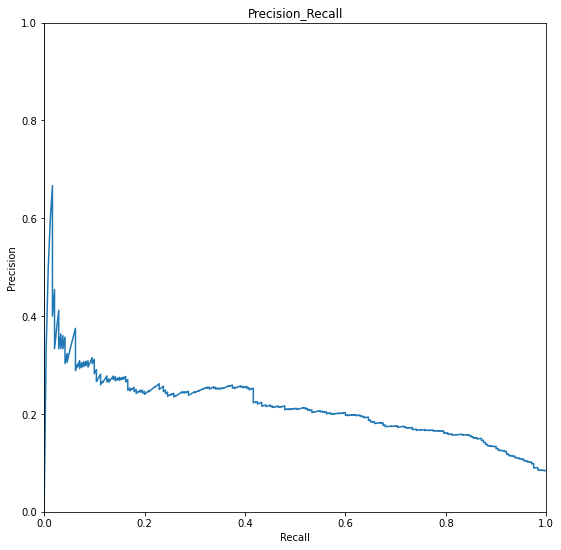

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# pd.DataFrame({'precision': precision, 'recall' : recall})
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Precision_Recall')

# Plot Precision-Recall curve
plt.plot(recall, precision)

# Axes limits and labels
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
# Calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)
f1score = 2*(tpr+fpr)/(tpr*fpr)
precision = tpr / (tpr + fpr)
recall = tpr
pd.DataFrame({'Precision': precision, 'Recall' : tpr, 'F1SCORE': f1score, 'Thresholds' : thresholds})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,Precision,Recall,F1SCORE,Thresholds
0,NaN,0.000000,NaN,1.720644
1,0.000000,0.000000,inf,0.720644
2,0.000000,0.000000,inf,0.620949
3,0.958333,0.016667,2880.000000,0.518554
4,0.884615,0.016667,1040.000000,0.474694
...,...,...,...,...
410,0.515055,0.991667,4.158832,0.015315
411,0.516102,0.995833,4.150394,0.015314
412,0.513211,0.995833,4.125744,0.014634
413,0.514254,1.000000,4.117376,0.014630


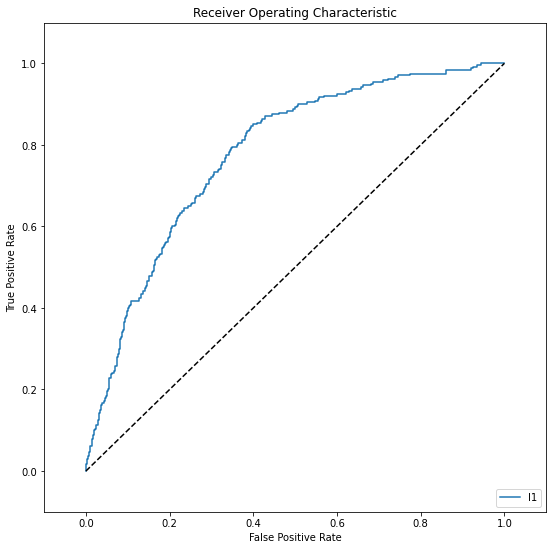

In [ ]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# AUROC
roc_auc_score(y_test, pred)

0.7772342995169083

In [ ]:
pred_class_v2 = (np.array(pred) > 0.2).astype(int)
cohen_kappa = cohen_kappa_score(y_test, pred_class_v2)
cohen_kappa

0.15306009108075092